In [3]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from numpy import *

In [4]:
data_dir=os.path.join('data')
classes=os.listdir(data_dir)
classes

['cats', 'dogs']

In [5]:
import cv2
import imghdr                                                                   #you can read image using either cv2 or matplotlib
                                                                                #cv2 uses BGR,matplotlib uses RGB
img_ext=['jpeg','jpg','png','bmp']                                              #if we use cv2,then convert imge to RGB to display

for img_c in classes:
    for img_v in os.listdir(os.path.join('data',img_c)):
        img_p=os.path.join('data',img_c,img_v)
        try:
            img_mat=cv2.imread(img_p)
            #plt.imread(img_p)
            #plt.imshow(k #an matrix of image)
            #plt.imshow(img_mat)     #gives BGR cv2 image
            img_tip=imghdr.what(img_p)
            if(img_tip not in img_ext):
                print('Image not in ext list {}'.format(img_p))
                os.remove(img_p)
            
        except Exception as e:
            #print('Issue with image {}'.format(img_p))
            print(e)

In [6]:
#LOADING DATA

In [7]:
data=tf.keras.utils.image_dataset_from_directory('data',image_size=(224,224))
#data=tf.keras.utils.image_dataset_from_directory('data',batch_size=8,)
data

Found 2000 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

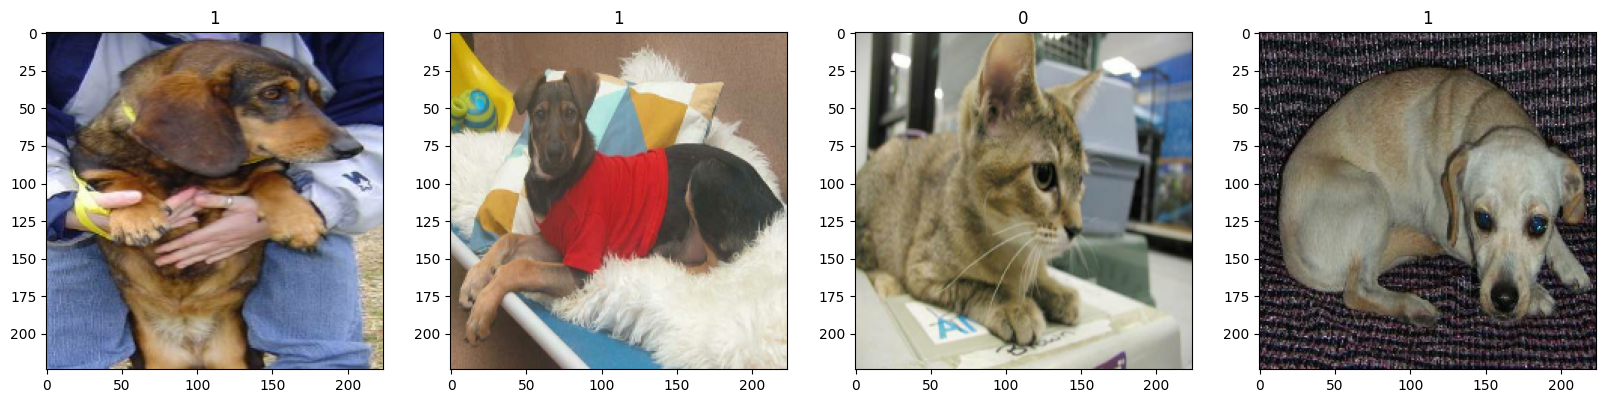

In [8]:
#--------PREPROCESSING DATA----------#

#optimizing the RGB values
#nbatch=batch[0]/255
#optimizing at the time of pipeline
data=data.map(lambda x,y:(x/255,y))    #x independent features,y dependent feature
scaled=data.as_numpy_iterator()
batch=scaled.next()


fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for i,j in enumerate(batch[0][:4]):
    ax[i].imshow(j)    #already in minimal scaled range
    ax[i].title.set_text(batch[1][i])

In [9]:
#splitting the dataSet
print(len(data))
train=int(0.7*len(data)) #train--->70%
val=int(0.2*len(data))  #test---->20%
test=int(0.1*len(data))   #validation----->10%
print(train,test,val)

#shuffle dataset
data=data.shuffle(10000,seed=12)

#taking data
train_ds=data.take(train)
val_ds=data.skip(train).take(val)
test_ds=data.skip(test+val).take(test)

63
44 6 12


In [10]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [12]:
model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
#TRAINING
tensor_call=tf.keras.callbacks.TensorBoard(log_dir='logs')
tensor_call
#using logs & call backs we can manage the learning phase at any instance

In [14]:
'''model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])'''
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

history=model.fit(train_ds,epochs=5,validation_data=val_ds,callbacks=[tensor_call])

Epoch 1/5
44/44 [==============================] - 82s 2s/step - loss: 0.2839 - accuracy: 0.9041 - val_loss: 0.0961 - val_accuracy: 0.9810
Epoch 2/5
44/44 [==============================] - 68s 2s/step - loss: 0.0771 - accuracy: 0.9815 - val_loss: 0.0492 - val_accuracy: 0.9948
Epoch 3/5
44/44 [==============================] - 68s 1s/step - loss: 0.0562 - accuracy: 0.9892 - val_loss: 0.0483 - val_accuracy: 0.9891
Epoch 4/5
44/44 [==============================] - 69s 2s/step - loss: 0.0432 - accuracy: 0.9899 - val_loss: 0.0453 - val_accuracy: 0.9870
Epoch 5/5
44/44 [==============================] - 70s 2s/step - loss: 0.0383 - accuracy: 0.9892 - val_loss: 0.0334 - val_accuracy: 0.9974


In [15]:
di=history.history #gives entire trained DL model info like loss,validation loss and accuracy
di

{'loss': [0.2839221954345703,
  0.0770658627152443,
  0.056182097643613815,
  0.04319651797413826,
  0.038310591131448746],
 'accuracy': [0.9041193127632141,
  0.9815340638160706,
  0.9892241358757019,
  0.9899425506591797,
  0.9892241358757019],
 'val_loss': [0.09606509655714035,
  0.049159642308950424,
  0.04832053557038307,
  0.04533703997731209,
  0.03337346389889717],
 'val_accuracy': [0.98097825050354,
  0.9947916865348816,
  0.989130437374115,
  0.9869791865348816,
  0.9973958134651184]}

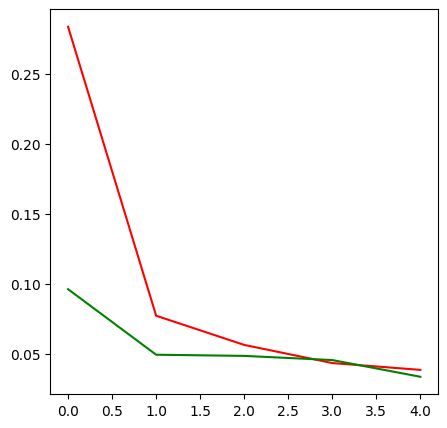

In [16]:
#<----PERFORMANCE------>

#LOSS VIZULATIZATION
plt.figure(figsize=(5,5))
plt.plot(di['loss'],color="red",label="loss")
plt.plot(di['val_loss'],color="green",label="val_loss")
plt.show()
#observe by considering Y axis for both--->graphs down means accuacry increasing

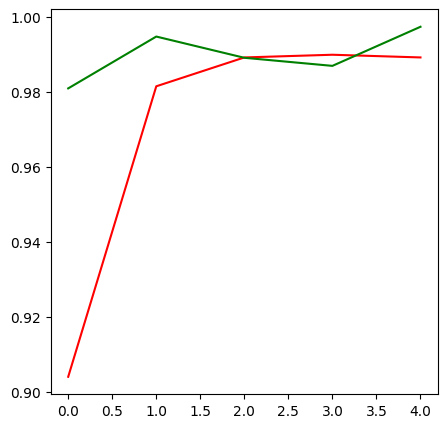

In [17]:
#ACCURACY VIZULIZATION
plt.figure(figsize=(5,5))
plt.plot(di['accuracy'],color="red",label="loss")
plt.plot(di['val_accuracy'],color="green",label="val_loss")
plt.show()

In [18]:
#evalute
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test_ds.as_numpy_iterator(): 
    X, y = batch     #X->holds images #y->holds lables
    res = model.predict(X)  #32 predictions for test data
    pre.update_state(y, res)
    re.update_state(y, res)
    acc.update_state(y, res)
print(pre.result(), re.result(), acc.result())

1/1 [==============================] - 1s 1s/step
tf.Tensor(0.9882353, shape=(), dtype=float32) tf.Tensor(0.9767442, shape=(), dtype=float32) tf.Tensor(0.984375, shape=(), dtype=float32)


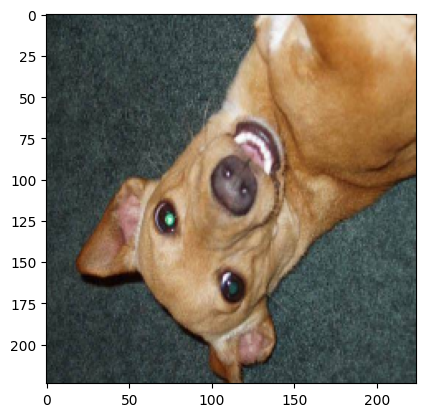

In [17]:
from numpy import *
#unseen prediction
img=plt.imread('my.jpg')
plt.imshow(img)

#resize according to layers
resize=tf.image.resize(img,(224,224))
plt.imshow(resize.numpy().astype(int)) #adjusted according to RGB b/w 0 to 1
plt.show()

#optimize the new image
resize=resize/255
#expand your image array
img=expand_dims(resize,0)

In [18]:
#prediction
pred=model.predict(img)
print(pred)

1/1 [==============================] - 1s 513ms/step
[[0.9960483]]


In [19]:
#since it is a binary classification

if pred[0]>0.5:
    print("DOG")
else:
    print("CAT")

DOG


In [1]:
from tensorflow.keras.models import load_model

In [21]:
model.save(os.path.join('dog or cat transfer classification.h5'))

In [2]:
new_model=load_model('dog or cat transfer classification.h5')

ValueError: Unknown layer: KerasLayer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [23]:
def pred(img1):
    #unseen prediction
    #img=plt.imread('my.jpg')
    #plt.imshow(img)

    #resize according to layers
    resize=tf.image.resize(img1,(224,224))
    plt.imshow(resize.numpy().astype(int)) #adjusted according to RGB b/w 0 to 1
    plt.show()

    #optimize the new image
    resize=resize/255
    #expand your image array
    img2=expand_dims(resize,0)
    return img2


In [24]:
images=[]
predictions=[]
from numpy import *

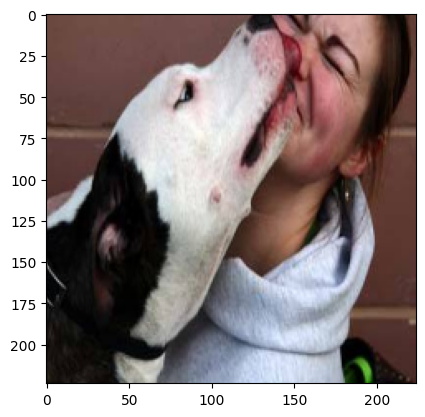

1/1 [==============================] - 0s 120ms/step


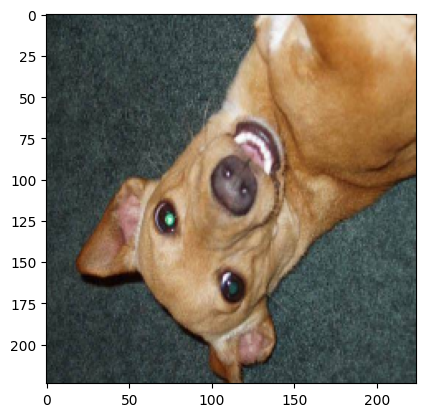

1/1 [==============================] - 0s 123ms/step


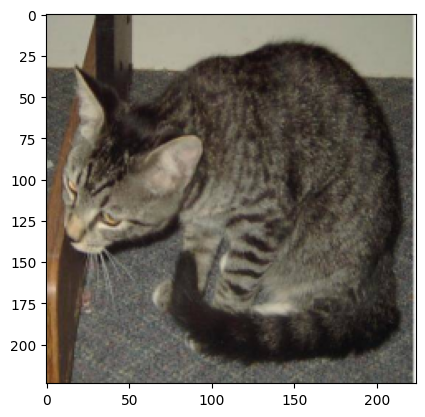

1/1 [==============================] - 0s 121ms/step


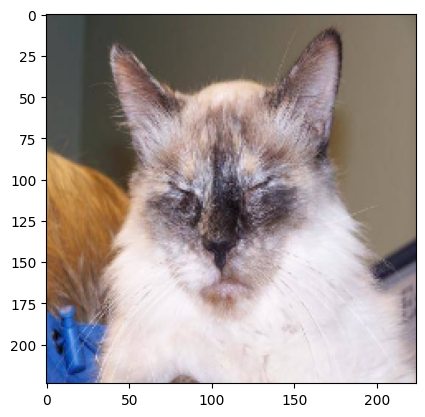

1/1 [==============================] - 0s 117ms/step


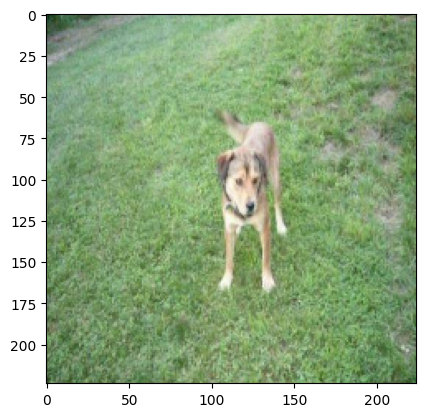

1/1 [==============================] - 0s 121ms/step


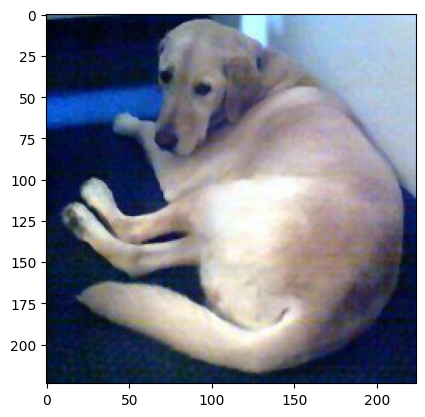

1/1 [==============================] - 0s 120ms/step


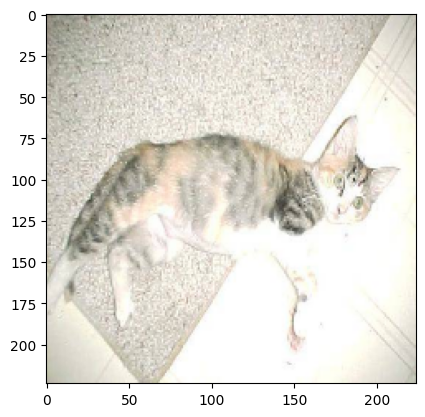

1/1 [==============================] - 0s 115ms/step


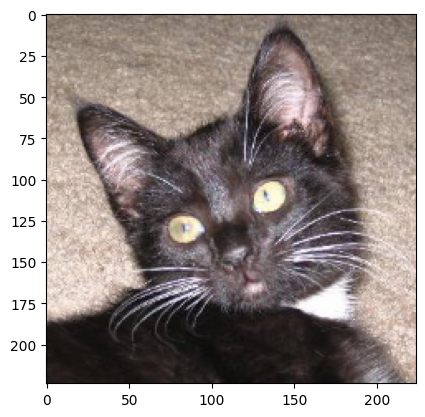

1/1 [==============================] - 0s 113ms/step


In [25]:
#loaded model prediticion
for i in range(8):
    img=plt.imread('my'+str(i)+'.jpg')
    imgn=pred(img)
    predictions.append(model.predict(imgn))
    images.append(img)

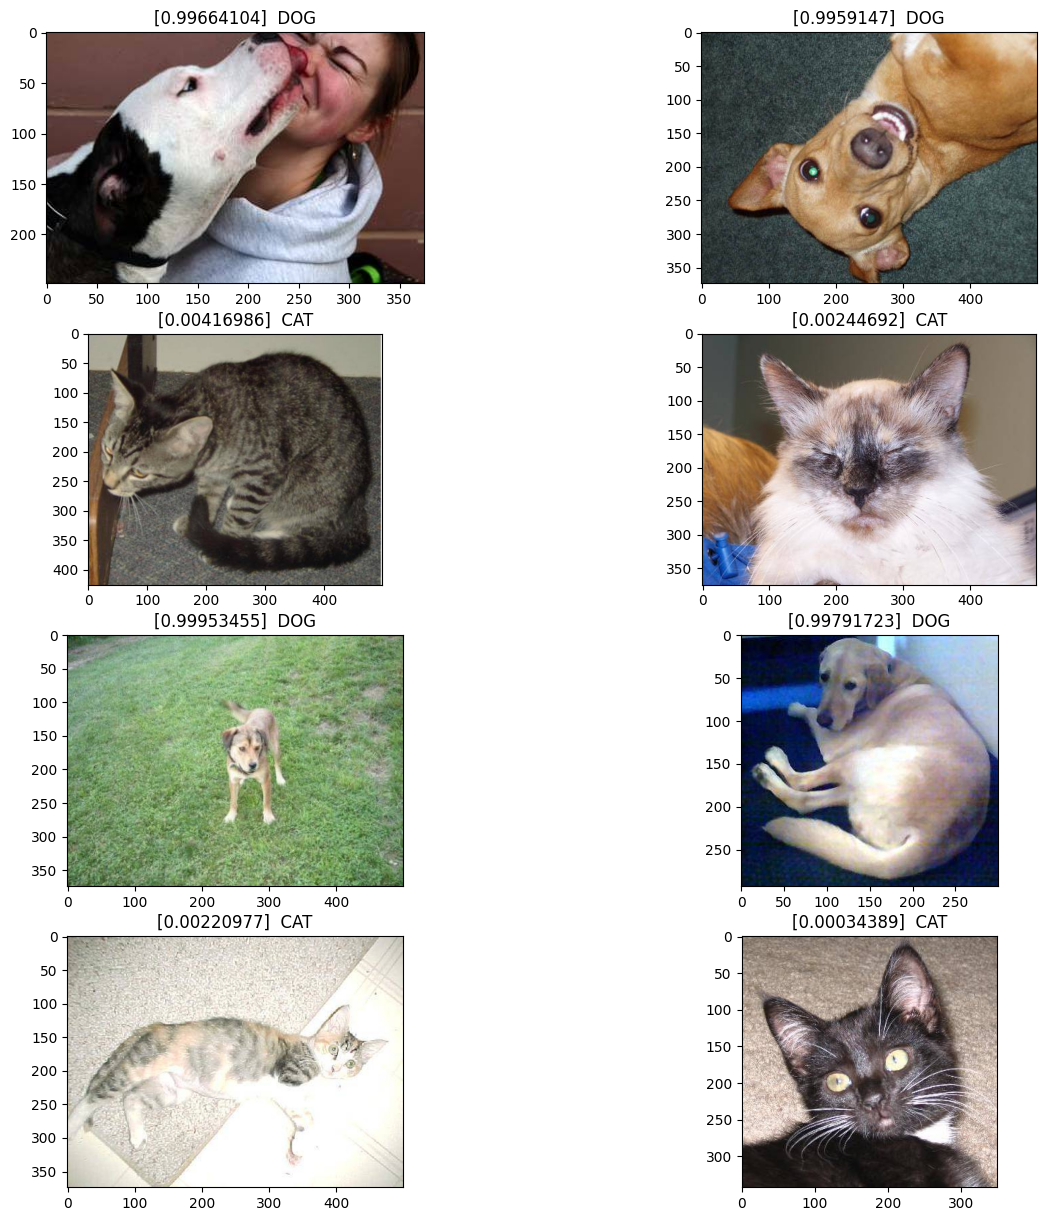

In [26]:
fig,ax=plt.subplots(nrows=4,ncols=2,figsize=(15,15))
ax=ax.flatten()
for i,j in enumerate(images[:8]):
    ax[i].imshow(j) #already in minimal scaled range
    if(predictions[i][0] > 0.5):
        ax[i].title.set_text(str(predictions[i][0])+"  DOG")
        #ax[i].title.set_text("DOG")
    else:
        ax[i].title.set_text(str(predictions[i][0])+"  CAT")
        #ax[i].title.set_text("CAT")